In [18]:
import ollama
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import json
import os

#removable
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from datetime import datetime

class SentimentClassifier:

    def __init__(self):
        self.model = AutoModelForSequenceClassification.from_pretrained('model')
        self.tokenizer = AutoTokenizer.from_pretrained('tokenizer')
        self.action_dict = {
            1: 'Positive',
            2: 'Slightly Positive',
            3: 'Moderately Negative',
            4: 'Strongly Negative',
            5: 'Extremly Negative'
        }
        self.class_dict = {
            1: 'Category 1',
            2: 'Category 2',
            3: 'Category 3',
            4: 'Category 4',
            5: 'Category 5'
        }

    def preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)

    def get_sentiment_from_roberta(self, text):
        encoded_input = self.tokenizer(text, return_tensors='pt')
        output = self.model(**encoded_input)
        scores = output[0][0].detach().numpy()
        # scores = output[0][0].cpu().detach().numpy()
        scores = softmax(scores)
        predicted_category = np.argmax(scores)
        return predicted_category
    
    def get_sentiment(self, text):
        cleaned_text = self.preprocess(text)

        # prompt = f"""
        #     You are a language model that classifies text into one of five categories based on tone, language, and potential harm. Read the definitions and examples carefully before classifying the input text.

        #     Categories:

        #     1 – Safe and Positive:
        #     Friendly, joyful, or optimistic content. Includes positive experiences, encouragement, support, or harmless jokes.
        #     Examples:
        #     - "Had such a wonderful day with my besties today!"
        #     - "Yes, well done! Absolutely rooting for you!"

        #     2 – Neutral or Slightly Negative:
        #     Emotionally neutral or mildly critical tone. May include casual complaints, mixed feelings, sarcasm without toxicity, or low-impact criticism.
        #     Examples:
        #     - "I really like McDonald's, but I know it's unhealthy."
        #     - "God, the gym class was tough today!"

        #     3 – Insults or Profanity (Not Hateful or Threatening):
        #     Toxic or offensive language using insults or profanity, but without any hate slurs or threats of violence. Emotionally charged or angry tone, usually directed at actions or individuals, not identity groups.
        #     Examples:
        #     - "Don't be a dick. We're all going out on Friday!"
        #     - "What the hell were you thinking, you dumbass?"
        #     - "This is absolute bullshit, I can’t take it anymore."

        #     4 – Hate Speech or Group-Based Offense (No Threats):
        #     Content that includes slurs, extreme derogatory language, or attacks based on identity (race, gender, religion, orientation, etc.). Hateful tone, but **no direct threat** or call to harm.
        #     Examples:
        #     - "Only f**gots block people."
        #     - "You filthy [racial slur], get out of my country."
        #     - "All [group] are trash and shouldn’t be allowed here."

        #     5 – Explicit Threats or Incitement to Harm:
        #     Statements that **threaten violence**, wish physical harm, or endorse or incite violent or criminal actions. May include hate slurs, but what matters most is **explicit violent intent**.
        #     Examples:
        #     - "I will chop your fucking head off if you talk to me like that again."
        #     - "Let’s shoot every last one of those [slur] bastards."
        #     - "You better kill yourself before I do it for you."

        #     Now determine the correct category for the new text.

        #     Text: "{cleaned_text}"

        #     Respond with only a single integer: 1, 2, 3, 4, or 5.
        # """

        prompt = f"""
        You are a language model that classifies text into one of the five categories based on tone and offensiveness.

        Categories:
        1 - Safe and Positive: Statements that are friendly, cheerful, or optimistic. Includes joy, encouragement, harmless fun, or clearly positive experiences.
        2 - Neutral or Slightly Negative: Statements with a neutral tone, mild criticism, or ambivalence. May include mixed feelings (e.g. "I like it, but...") or casual remarks without strong emotion.
        3 - Content with a moderate level of offensiveness. Tone is rude, angry, or sarcastic. May contain insults or profanity out of frustration (e.g. calling someone an "idiot" or saying "this is bullshit"), **but no hate slurs or explicit threats** of violence.
        4 - Content with a high level of offensiveness or hate. Tone is extremely aggressive, angry, or hateful. Often includes strong profanity and **slurs or very derogatory insults** targeting a person or group. May express hateful views or minor threats (e.g. using a slur or saying "I hate you all" with aggression), **but not an explicit serious violent threat**.
        5 - Content that is extremely offensive, violent, or harmful. Tone is extremely hostile or malicious. Contains **explicit threats of severe violence**, or encouragement of heinous acts, or extremely hateful language (e.g. threats to kill, rape, or harm someone, or multiple hate slurs and calls for violence).

        Examples:
        Text: "Don't be a dick. We're all going out on Friday! and text that contains shit, suicidal, deaths etc.,"
        Category: 3

        Text: "Only f**gots block people and text that usually contains bitch, fuck, drugs, genitals"
        Category: 4

        Text: "I will chop your fucking head off if you speak to me like that again and text that contains offensive words in more aggressive way"
        Category: 5

        Now determine the correct category for the new text.

        Text: "{cleaned_text}"

        Respond with only a single integer: 1, 2, 3, 4, or 5.
        """

        
        response = ollama.chat(model="gemma3:12b", messages=[{"role": "user", "content": prompt}])
        try:
            classified_category = int(response["message"]["content"].strip())
        except ValueError:
            # classified_category = self.get_sentiment_from_roberta(cleaned_text)
            classified_category = 0
            
        return classified_category 

    def predict(self, text):
        flag = int(self.get_sentiment(text))
        category = self.class_dict[flag]
        action = self.action_dict[flag]

        return flag, category, action
    

class Reasoner:
    def __init__(self, text, file_path):
        self.text = self.preprocess(text)
        self.offense_types_str = json.dumps(json.load(open(file_path, 'r')), indent=4)

    def generate_response(self):
        prompt = f"""
        Match the given negative statement with one of the given categories and give reason in strictly <50 words:
        - Statement: {self.text}
        - Categories: {self.offense_types_str}
        """
        
        response = ollama.chat(model="gemma3:12b", messages=[{"role": "user", "content": prompt}])
        return response["message"]["content"].strip() 

In [19]:
def test_on_df(classifier):
    df = pd.read_csv('./data/shimmy/cleaned.csv')
    # df = df[df['Category'].isin([3, 4, 5])]
    df['Text'] = df['Text'].astype('str')

    y = df['Category']
    preds = []

    for index, row in tqdm(df.iterrows(), desc='Processing: ', total=len(df)):
        text = row['Text']
        flag, category, action = classifier.predict(text)
        preds.append(flag)

    acc_score = accuracy_score(y, preds)
    cm = confusion_matrix(y, preds)

    print(acc_score)
    print(cm)

    data = pd.DataFrame(
        {
            'text': df['Text'],
           'Actual': y,
            'Preds': preds
        }
    )

    data.to_csv('./data/npreds.csv')

    # Save logs and metrics to txt
    log_path = './data/evaluation_log.txt'
    with open(log_path, 'w') as f:
        f.write("==== Sentiment Classification Evaluation Log ====\n")
        f.write(f"Timestamp: {datetime.now()}\n")
        f.write(f"LLM Engine: Gemma3, Params: 12b")
        f.write(f"Model: {classifier.model.name_or_path}\n")
        f.write(f"Tokenizer: {classifier.tokenizer.name_or_path}\n")
        f.write(f"Number of samples: {len(df)}\n")
        f.write(f"\nAccuracy Score: {acc_score:.4f}\n")
        f.write(f"\nConfusion Matrix:\n{cm}\n")
        f.write("\n\nLog saved successfully.\n")

    


if __name__=='__main__':

    offense_types_file_path = os.path.join('data', 'harm_categories.json')
    classifier = SentimentClassifier()
    # text = input("Enter Comment: ")
    # flag, category, action = classifier.predict(text)
    
    # print(flag)
    # print("Comment: ", text)
    # print(f"Category: {category}\nAction: {action}")


    # if flag==0:
    #     reasoner = Reasoner(text, offense_types_file_path)
    #     response = reasoner.generate_response()

    #     print("Reason: ", response)


    test_on_df(classifier)

Processing: 100%|██████████| 533/533 [09:12<00:00,  1.04s/it]

0.726078799249531
[[120  16   0   0   0]
 [  9  97   1   0   0]
 [  1   6  16   1   0]
 [  0   5  31  81  22]
 [  0   2   3  49  73]]


In [20]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

preds = pd.read_csv('./data/npreds.csv')
ypred, ytest = preds['Preds'], preds['Actual']
acc = accuracy_score(ytest, ypred)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred, output_dict=True)

In [21]:
print('Accuracy Score: ', acc)

Accuracy Score:  0.726078799249531


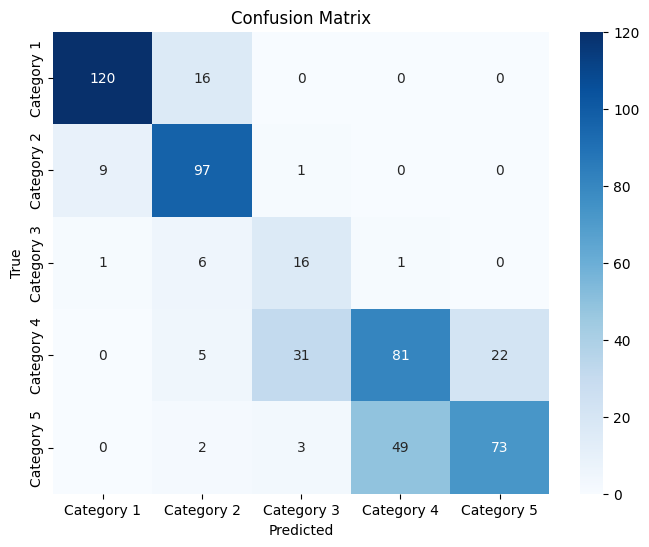

In [22]:
classes = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [25]:
cr_str = classification_report(ytest, ypred)

In [28]:
print(cr_str)

              precision    recall  f1-score   support

           1       0.92      0.88      0.90       136
           2       0.77      0.91      0.83       107
           3       0.31      0.67      0.43        24
           4       0.62      0.58      0.60       139
           5       0.77      0.57      0.66       127

    accuracy                           0.73       533
   macro avg       0.68      0.72      0.68       533
weighted avg       0.75      0.73      0.73       533



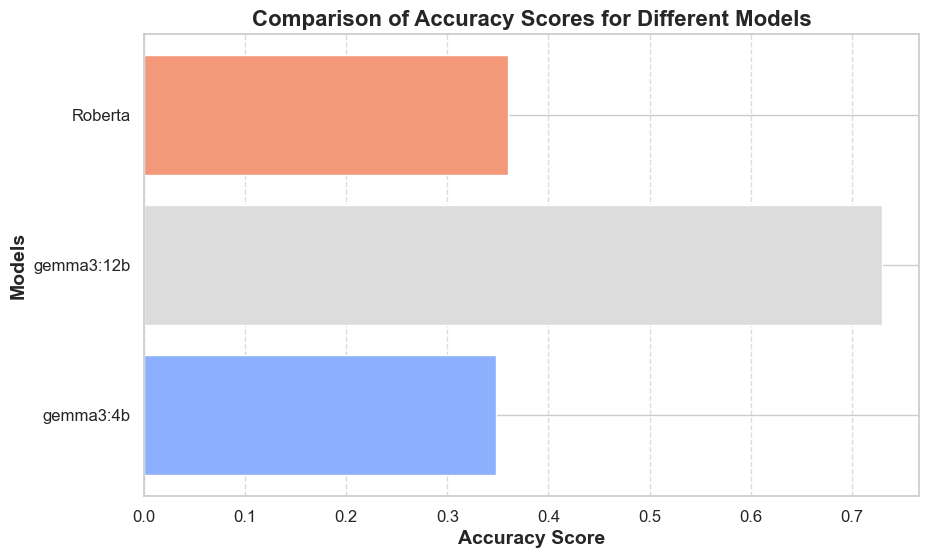

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more professional and elegant style
sns.set_theme(style="whitegrid", palette="muted")

models = ['gemma3:4b', 'gemma3:12b', 'Roberta']
accuracy_scores = [0.34782608695652173, 0.73, 0.360054347826087]

# Plotting the horizontal bar graph with a more refined style
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_scores, color=sns.color_palette("coolwarm", len(models)))

# Adding labels and title
plt.xlabel('Accuracy Score', fontsize=14, weight='bold')
plt.ylabel('Models', fontsize=14, weight='bold')
plt.title('Comparison of Accuracy Scores for Different Models', fontsize=16, weight='bold')

# Adjusting tick parameters for a professional look
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.show()